## Part 1 - Exploratory Data Analysis

In [1]:
# load json file
import json
with open('logins.json') as l:
  data = json.load(l)

# print out keys
print(data.keys())

dict_keys(['login_time'])


In [2]:
# only dictionary key is login time
# convert it to one column dataframe
import pandas as pd
df = pd.DataFrame(data)
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null object
dtypes: object(1)
memory usage: 727.8+ KB


In [4]:
# no missing data exists 
# convert string to datetime
import datetime as dt

df = df.apply(lambda row: dt.datetime.strptime(row['login_time'], '%Y-%m-%d %H:%M:%S'), axis = 1)
df = pd.DataFrame(df, columns = ['time'])
df.head()

,time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
# create a temp column with 1 counts of all times and aggregate by 15 minutes
df1 = df.copy()
df1['count'] = 1
df1.set_index('time', inplace=True)
df1 = df1.resample('15Min').count()
df1 = df1.reset_index()
df1.head()

,time,count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


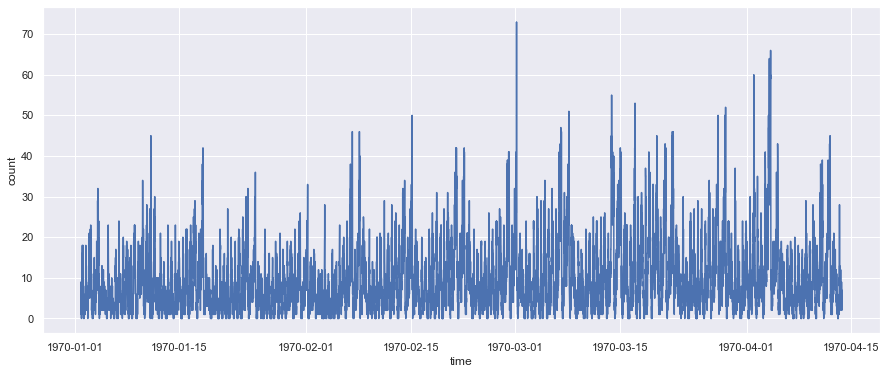

In [6]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

# import seaborn and matplotlib, display plot
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
sns.set(style="darkgrid")
sns.lineplot(x="time", y="count",
             data=df1)
plt.show()

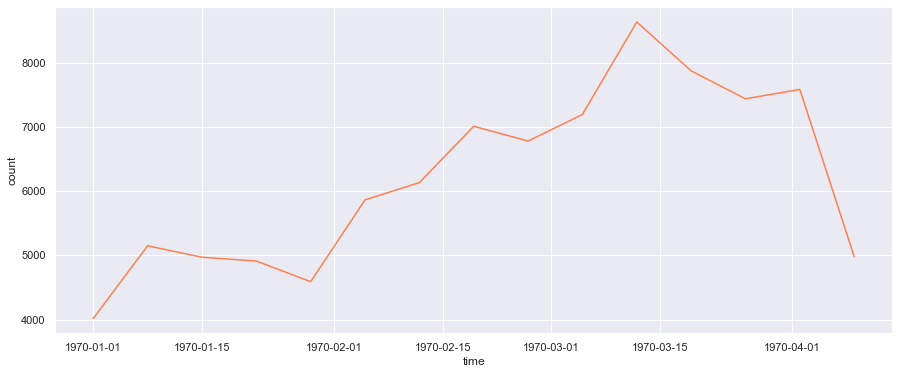

In [7]:
df2 = df.copy()
df2['count'] = 1
# to gain more insight, resample by 7 day intervals and replot seaborn figure
df2.set_index('time', inplace=True)
df2 = df2.resample('7D').count()
df2 = df2.reset_index()
plt.figure(figsize=(15,6))
sns.set(style="darkgrid")
sns.lineplot(x="time", y="count",
             data=df2,color="coral")
plt.show()

In [8]:
df3 = df.copy()
df3['count'] = 1
df3.set_index('time', inplace=True)
df3 = df3.resample('H').count()
df3 = df3.reset_index()
df3["hour"] = [t.hour for t in pd.to_datetime(df3.time)]
df3.head()

,time,count,hour
0,1970-01-01 20:00:00,24,20
1,1970-01-01 21:00:00,9,21
2,1970-01-01 22:00:00,21,22
3,1970-01-01 23:00:00,58,23
4,1970-01-02 00:00:00,53,0


In [10]:
df3_bar = df3.groupby(['hour'])['count'].sum().reset_index()
df3_bar.head()

,hour,count
0,0,5993
1,1,6317
2,2,5800
3,3,4831
4,4,5034


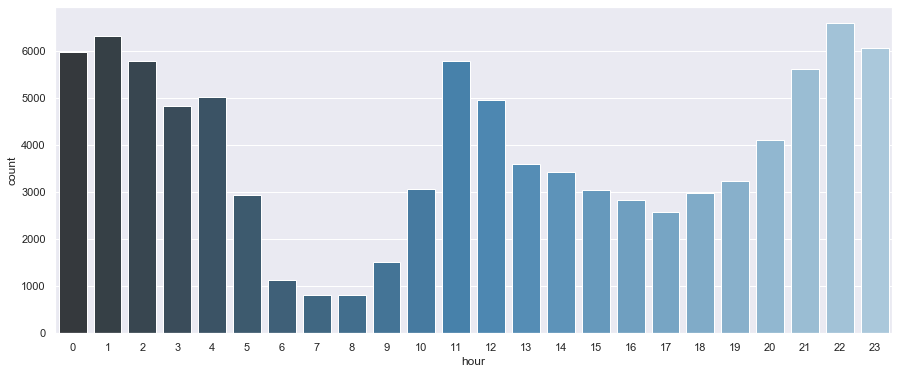

In [11]:
plt.figure(figsize=(15,6))
sns.barplot(x="hour", y="count", data=df3_bar, palette = "Blues_d")

In [12]:
def dow(date):
    days=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    dayNumber=date.weekday()
    return(days[dayNumber])

In [13]:
df1['dow'] = df1.apply(lambda row: dow(row['time']), axis = 1)

In [14]:
df_dow = df1.groupby(['dow'])['count'].sum().reset_index()
df_dow

,dow,count
0,Friday,15208
1,Monday,8823
2,Saturday,19377
3,Sunday,18167
4,Thursday,11960
5,Tuesday,9268
6,Wednesday,10339


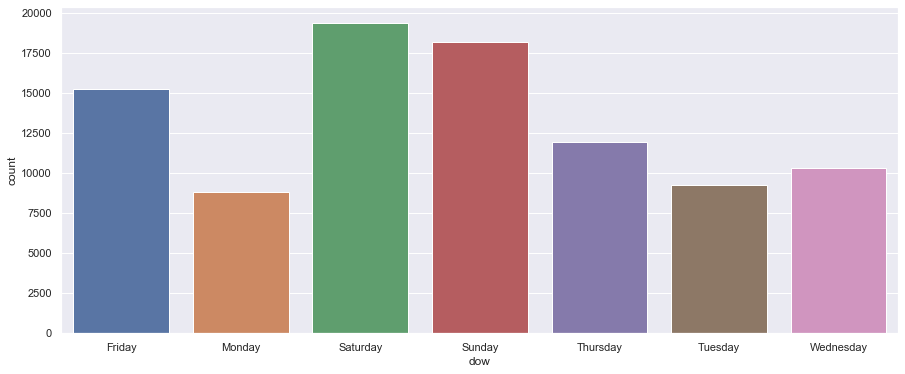

In [15]:
plt.figure(figsize=(15,6))
sns.barplot(x="dow", y="count", data=df_dow)

## Conclusion
1. User logins have been increasing since Jan. 

2. Logins usually happen around midnight and noon.

3. Most users login during Friday, Saturday and Sunday. 

## Part 2 - Experiment and Metric Designs

The Ultimate managers of city operations for the Gotham and Metropolis have proposed an experiment to encourage 
driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a. how you will implement the experiment

b. what statistical test(s) you will conduct to verify the significance of the
observation

c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

##### Answer #1
Assuming that both Metropolis and Gotham shares a system similar to EZ Pass of the Northeastern US, the **primary metric** to choose would be "count of toll charges by license plate zip code". Normally a license plate would be tied to a driver and that driver would have a resident that's linked to a zip code, using that zip code we can identify where the driver starts out from and see how frequently the driver is charged by the toll. **Secondary metrics** we could look at are toll timestamp, toll amount, reimbursement amount, these metrics can help us predict what additional incentives should be used to encourage traveling between cities, such as lower toll amounts during a certain time of day.

##### Answer #2 (a,b)

To measure the effectiveness of the toll incentive, we would sample the data and split it into two groups. One group contains the users who had incentive and the other group contains users who did not have incentive. The null hypothesis would be written as there is no difference for toll crossings between users that had reimbursement incentives and users that did not have reimbursement incentives. We can then use a z-test to reject or accept the hypothesis.

A few things to consider are: we need to make sure enough people sign up for the incentive in order for the test to work; at 95% confidence, we have 1 in 20 chance of being wrong for the given metric; in the unlikely event that the sample size collected were too small, we can try bootstrapping. 

##### Answer #2 (c)

Using the test, we can see whether or not the incentive works. If it works, we can then move on to A/B testing and run a series of tests to see how much the incentives works by increasing or decreasing the amount. Using the test we can narrow down the range as to what incentive is the most effective in encouraging toll passes between the two cities.

## Part 3 ‑ Predictive modeling

In [27]:
# load json file
with open('ultimate_data_challenge.json') as l:
  data = json.load(l)

# print out first 5 entries
print(data[:3])

[{'city': "King's Landing", 'trips_in_first_30_days': 4, 'signup_date': '2014-01-25', 'avg_rating_of_driver': 4.7, 'avg_surge': 1.1, 'last_trip_date': '2014-06-17', 'phone': 'iPhone', 'surge_pct': 15.4, 'ultimate_black_user': True, 'weekday_pct': 46.2, 'avg_dist': 3.67, 'avg_rating_by_driver': 5.0}, {'city': 'Astapor', 'trips_in_first_30_days': 0, 'signup_date': '2014-01-29', 'avg_rating_of_driver': 5.0, 'avg_surge': 1.0, 'last_trip_date': '2014-05-05', 'phone': 'Android', 'surge_pct': 0.0, 'ultimate_black_user': False, 'weekday_pct': 50.0, 'avg_dist': 8.26, 'avg_rating_by_driver': 5.0}, {'city': 'Astapor', 'trips_in_first_30_days': 3, 'signup_date': '2014-01-06', 'avg_rating_of_driver': 4.3, 'avg_surge': 1.0, 'last_trip_date': '2014-01-07', 'phone': 'iPhone', 'surge_pct': 0.0, 'ultimate_black_user': False, 'weekday_pct': 100.0, 'avg_dist': 0.77, 'avg_rating_by_driver': 5.0}]


In [28]:
# convert to dataframe
df = pd.DataFrame.from_dict(data, orient='columns')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [29]:
# convert date time and calculate current date using Max function
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
current_date = max(df['last_trip_date'])
current_date - dt.timedelta(days=30)

Timestamp('2014-06-01 00:00:00')

In [30]:
# identify active users
import numpy as np
df['active'] = np.where(df['last_trip_date'] > dt.datetime(2014, 6, 1), 1, 0)
df_counts = df['active'].value_counts()

## in multi-condition situation, use select:
## conditions = [
##    (df['phone'] == 'Iphone') & (df['ultimate_black_user'] == False),
##    (df['phone'] == 'Windows')]
## choices = ['white', 'blue']
## df['color'] = np.select(conditions, choices, default='black')

In [31]:
# thus retention rate is
print(df_counts[1]/(df_counts[0]+df_counts[1]))

0.3662


Since we do not have a transactional table or a periodic snapshot table, we are unable to see how retention rate changed over time and so we do not know if 36.62% is a good retention rate.

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
active                    50000 non-null int32
dtypes: bool(1), datetime64[ns](2), float64(6), int32(1), int64(1), object(2)
memory usage: 4.4+ MB


In [33]:
# avg_rating_of_driver, avg_rating_by_driver contain missing data that can be filled with mean scores
def sc_mean(var, dataframe):
    dataframe[var].fillna(dataframe[var].mean(),inplace=True)

sc_mean('avg_rating_by_driver',df)
sc_mean('avg_rating_of_driver',df)

In [38]:
# choose the features that can be fitted in ML model 
df = df[['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge','surge_pct','ultimate_black_user',
         'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'active']]
df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,4,4.7,1.10,15.4,True,46.2,3.67,5.0,1
1,0,5.0,1.00,0.0,False,50.0,8.26,5.0,0
2,3,4.3,1.00,0.0,False,100.0,0.77,5.0,0
3,9,4.6,1.14,20.0,True,80.0,2.36,4.9,1
4,14,4.4,1.19,11.8,False,82.4,3.13,4.9,0


In [40]:
# define dependent and independent variables
x = df.drop(['active'], axis=1)
y = df['active']

In [43]:
# Store categorical column names
categorical = x.nunique()[x.nunique() < 10].keys().tolist()

# Store numerical column names
numerical = [i for i in x.columns if i not in categorical]

In [44]:
from sklearn.preprocessing import StandardScaler
# Initialize StandardScaler instance
scaler = StandardScaler()

# Fit and transform the scaler on numerical columns
scaled_numerical = scaler.fit_transform(x[numerical])

# Build a DataFrame from scaled_numerical
scaled_numerical = pd.DataFrame(scaled_numerical, columns=numerical)

In [50]:
# merge the binary categorical frame with the numerical frame
df_x = pd.DataFrame((df['ultimate_black_user'] == True ).astype(int))
x = pd.concat([scaled_numerical, df_x], axis=1)

In [52]:
x.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,ultimate_black_user
0,0.453984,0.174240,0.113506,0.328202,-0.397131,-0.372650,0.497684,1
1,-0.600689,0.705241,-0.336268,-0.443394,-0.294653,0.431583,0.497684,0
2,0.190316,-0.533761,-0.336268,-0.443394,1.053741,-0.880771,0.497684,0
3,1.772325,-0.002760,0.293416,0.558679,0.514383,-0.602181,0.273342,1
4,3.090665,-0.356760,0.518303,0.147829,0.579106,-0.467266,0.273342,0


In [123]:
# train, test, split and then fit logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

train_X, test_X, train_Y, test_Y = train_test_split(x, y, test_size= .25)

logreg = LogisticRegression(solver = 'lbfgs')
logreg.fit(train_X, train_Y)
pred_test_Y = logreg.predict(test_X)

In [124]:
# print the accuracy score
from sklearn.metrics import accuracy_score
print(accuracy_score(test_Y, pred_test_Y))

0.67768


In [125]:
# hypertune the model
C = [1, .5, .25, .1, .05, .025, .01, .005, .0025]
l1_metrics = np.zeros((len(C), 5))
l1_metrics[:,0] = C

In [126]:
l1_metrics

array([[1.    , 0.    , 0.    , 0.    , 0.    ],
       [0.5   , 0.    , 0.    , 0.    , 0.    ],
       [0.25  , 0.    , 0.    , 0.    , 0.    ],
       [0.1   , 0.    , 0.    , 0.    , 0.    ],
       [0.05  , 0.    , 0.    , 0.    , 0.    ],
       [0.025 , 0.    , 0.    , 0.    , 0.    ],
       [0.01  , 0.    , 0.    , 0.    , 0.    ],
       [0.005 , 0.    , 0.    , 0.    , 0.    ],
       [0.0025, 0.    , 0.    , 0.    , 0.    ]])

In [127]:
from sklearn.metrics import recall_score, precision_score
# Model Tuning
# Run a for loop over the range of C list length
for index in range(0, len(C)):
    # Initialize and fit Logistic Regression with the C candidate
    logreg = LogisticRegression(penalty='l1', C=C[index], solver='liblinear')
    logreg.fit(train_X, train_Y)
    # Predict churn on the testing data
    pred_test_Y = logreg.predict(test_X)
    # Create non-zero count and recall score columns
    l1_metrics[index,1] = np.count_nonzero(logreg.coef_)
    l1_metrics[index,2] = recall_score(test_Y, pred_test_Y, pos_label=1)
    l1_metrics[index,3] = precision_score(test_Y, pred_test_Y, pos_label=1)
    l1_metrics[index,4] = accuracy_score(test_Y, pred_test_Y)

# Name the columns and print the array as pandas DataFrame
col_names = ['C','Non-Zero Coeffs','Recall','Precision','Accuracy']
print(pd.DataFrame(l1_metrics, columns=col_names))

        C  Non-Zero Coeffs    Recall  Precision  Accuracy
0  1.0000              8.0  0.272847   0.640000   0.67776
1  0.5000              8.0  0.272847   0.640000   0.67776
2  0.2500              8.0  0.272191   0.639445   0.67752
3  0.1000              8.0  0.270442   0.638946   0.67712
4  0.0500              8.0  0.268037   0.638874   0.67672
5  0.0250              8.0  0.263664   0.639110   0.67608
6  0.0100              8.0  0.253607   0.648407   0.67656
7  0.0050              6.0  0.237866   0.669127   0.67808
8  0.0025              3.0  0.206384   0.676218   0.67344


In [129]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[6574 1296]
 [3904  726]]


In [130]:
# Combine feature names and coefficients into pandas DataFrame
feature_names = pd.DataFrame(train_X.columns, columns = ['Feature'])
log_coef = pd.DataFrame(np.transpose(logreg.coef_), columns = ['Coefficient'])
coefficients = pd.concat([feature_names, log_coef], axis = 1)

# Calculate exponent of the logistic regression coefficients
coefficients['Exp_Coefficient'] = np.exp(coefficients['Coefficient'])

# Remove coefficients that are equal to zero
coefficients = coefficients[coefficients['Coefficient']!=0]

# Print the values sorted by the exponent coefficient
print(coefficients.sort_values(by=['Exp_Coefficient']))

                  Feature  Coefficient  Exp_Coefficient
5                avg_dist    -0.115918         0.890548
0  trips_in_first_30_days     0.426531         1.531934
7     ultimate_black_user     0.565062         1.759557


Based on the results, we can see that hypertuning the model does not yield significant accuracy increases within the model. The accuracy for this model is around 67-68%. Upon looking at the coefficients, we can see that feature "avg_dist", "trips_in_first_30_days","ultimate_black_user" are the most important features within the model. Ultimate should consider increasing more ultimate_black_user and encourage people to take more trips in the first 30 days. The frequent usage of the service does contribute to the user experience.